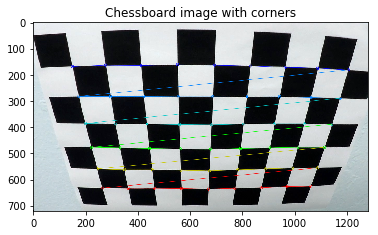

In [1]:
import os
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
from scipy.signal import find_peaks_cwt
%matplotlib inline

# load chessboard images
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)

# interior corners
nx = 9 
ny = 6 

# convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# if found, draw corners
if ret == True:
    # draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)
    plt.title("Chessboard image with corners")
    plt.show()

camera_cal/calibration2.jpg
camera_cal/calibration3.jpg
camera_cal/calibration6.jpg
camera_cal/calibration7.jpg
camera_cal/calibration8.jpg
camera_cal/calibration9.jpg
camera_cal/calibration10.jpg
camera_cal/calibration11.jpg
camera_cal/calibration12.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration15.jpg
camera_cal/calibration16.jpg
camera_cal/calibration17.jpg
camera_cal/calibration18.jpg
camera_cal/calibration19.jpg
camera_cal/calibration20.jpg


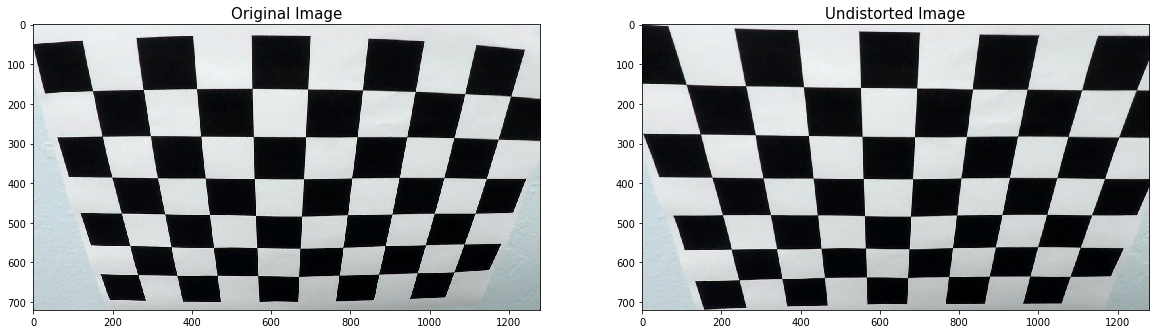

In [2]:
# prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

# arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# step through all images and search for chessboard corners
for i in range(1,21):
    fname = 'camera_cal/calibration{}.jpg'.format(i)
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

    # if found, add object points, image points
    if ret == True:
        print(fname)
        objpoints.append(objp)
        imgpoints.append(corners)

        # draw and display the corners
        cv2.drawChessboardCorners(img, (8,6), corners, ret)
        cv2.imshow('img', img)
        
# test the undistortion on an image
fname = 'camera_cal/calibration{}.jpg'.format(2)
img = cv2.imread(fname)
img_size = (img.shape[1], img.shape[0])

# perform camera calibration
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('calibration_wide/test_undist.jpg',dst)

# save the camera calibration
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

# test undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=15)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=15)

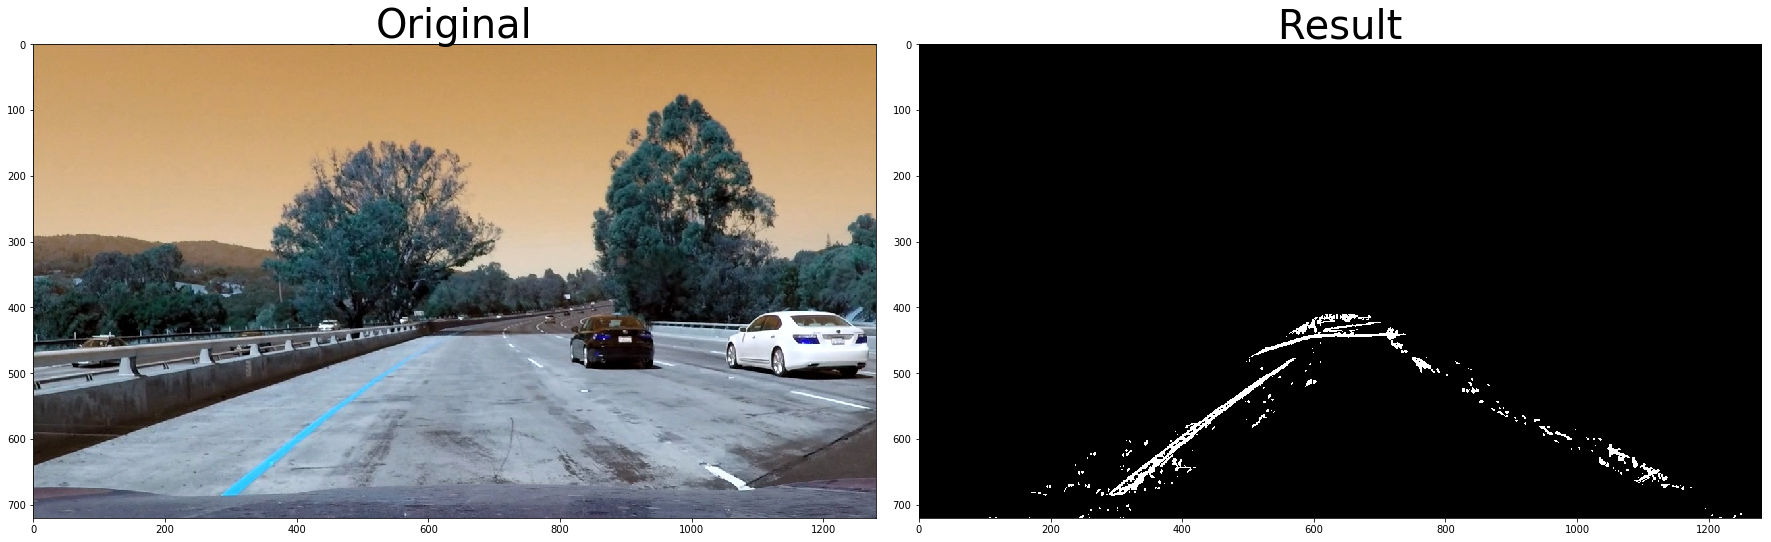

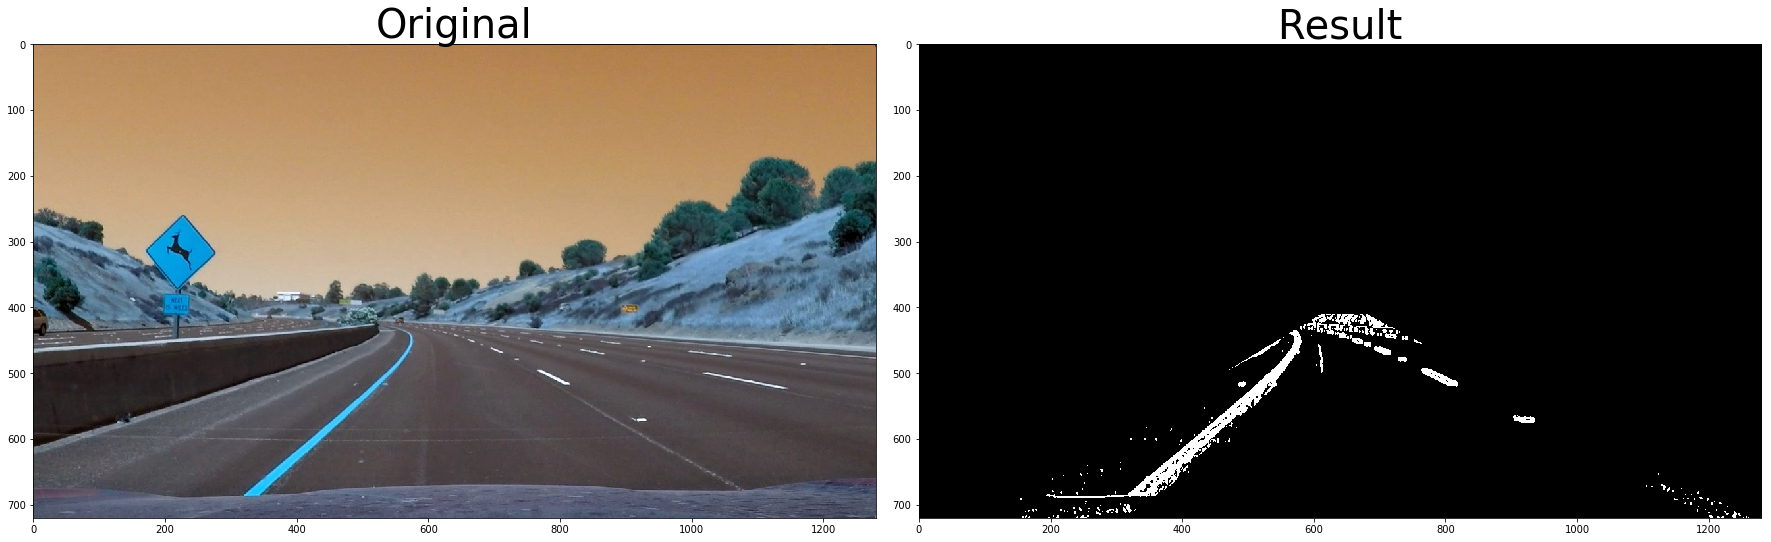

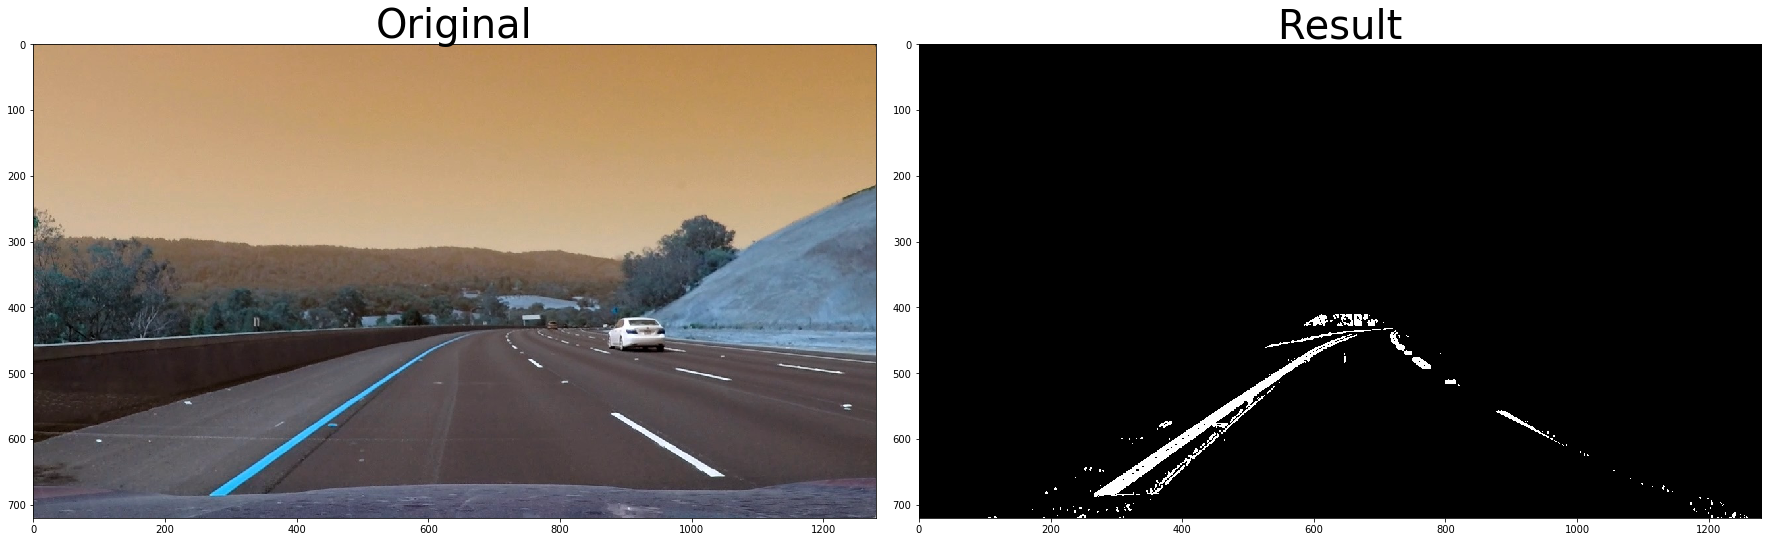

In [3]:
# setup helper functions

def region_of_interest(img, vertices):
    
    # define a blank mask
    mask = np.zeros_like(img)   
    
    # create a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# calculate directional gradient
def abs_sobel_thresh(gray, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # x or y gradient
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # absolute value
    sobel = np.absolute(sobel)
    
    # convert to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1])] = 1
    
    return binary_output

# calculate gradient magnitude
def magnitude_threshold(gray, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # gradient magnitude
    sobel = np.sqrt(sobelx ** 2 + sobely ** 2)
    
    # convert back to 8 bit integer
    scaled_sobel = np.uint8(255*sobel/np.max(sobel))
    
    # create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1])] = 1
    
    return binary_output

# calculate gradient direction
def direction_threshold(gray, sobel_kernel=3, thresh=(0, np.pi/2)):
    # x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # error statement to ignore division and invalid errors
    with np.errstate(divide='ignore', invalid='ignore'):
        absgraddir = np.absolute(np.arctan(sobely/sobelx))
        dir_binary =  np.zeros_like(absgraddir)
        dir_binary[(absgraddir > thresh[0]) & (absgraddir < thresh[1])] = 1

    return dir_binary

def highlight_lane_lines(img):
    
    # gaussian Blur
    kernel_size = 5
    img = cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)
    
    # convert to HLS color space and separate the S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s = hls[:,:,2]
    
    # grayscale image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # define sobel kernel size
    kernel_size = 7
    
    # apply thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=kernel_size, thresh=(10, 255))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=kernel_size, thresh=(60, 255))
    mag_binary = magnitude_threshold(gray, sobel_kernel=kernel_size, mag_thresh=(40, 255))
    dir_binary = direction_threshold(gray, sobel_kernel=kernel_size, thresh=(.65, 1.05))
    
    # combine thresholding information
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) + (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    # shreshold S channel
    s_binary = np.zeros_like(combined)
    s_binary[(s > 160) & (s < 255)] = 1
    
    # stack each channel to view their individual contributions 
    color_binary = np.zeros_like(combined)
    color_binary[(s_binary > 0) | (combined > 0)] = 1
    
    
    # define vertices for marked area (deprecated)
    imshape = img.shape
    left_bottom = (100, imshape[0])
    right_bottom = (imshape[1]-20, imshape[0])
    apex1 = (610, 410)
    apex2 = (680, 410)
    inner_left_bottom = (310, imshape[0])
    inner_right_bottom = (1200, imshape[0])
    inner_apex1 = (720,480)
    inner_apex2 = (650,480)
    vertices = np.array([[left_bottom, apex1, apex2, \
                          right_bottom, inner_right_bottom, \
                          inner_apex1, inner_apex2, inner_left_bottom]], dtype=np.int32)
    
    # masked area
    color_binary = region_of_interest(color_binary, vertices)
    return color_binary



######## process sample images #########
    
for i in range(1,4):
    fname = 'test_images/test{}.jpg'.format(i)
    image = cv2.imread(fname)
    result = highlight_lane_lines(image)

    # Plot the result
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()

    ax1.imshow(image)
    ax1.set_title('Original', fontsize=40)

    ax2.imshow(result, cmap='gray')
    ax2.set_title('Result', fontsize=40)
   
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

image shape: (720, 1280, 3)


/home/eric/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:122: RuntimeWarning: divide by zero encountered in double_scalars
/home/eric/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2889: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/eric/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


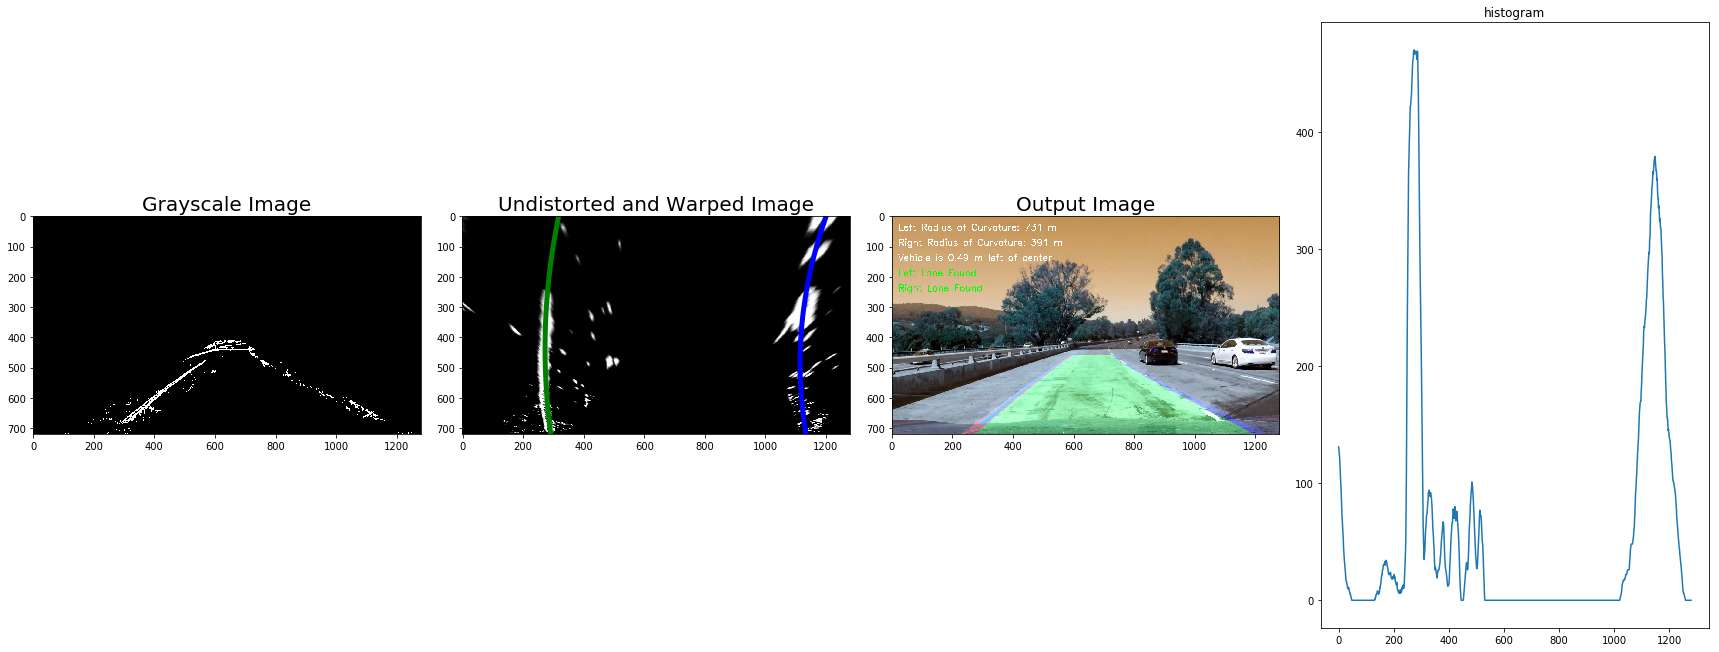

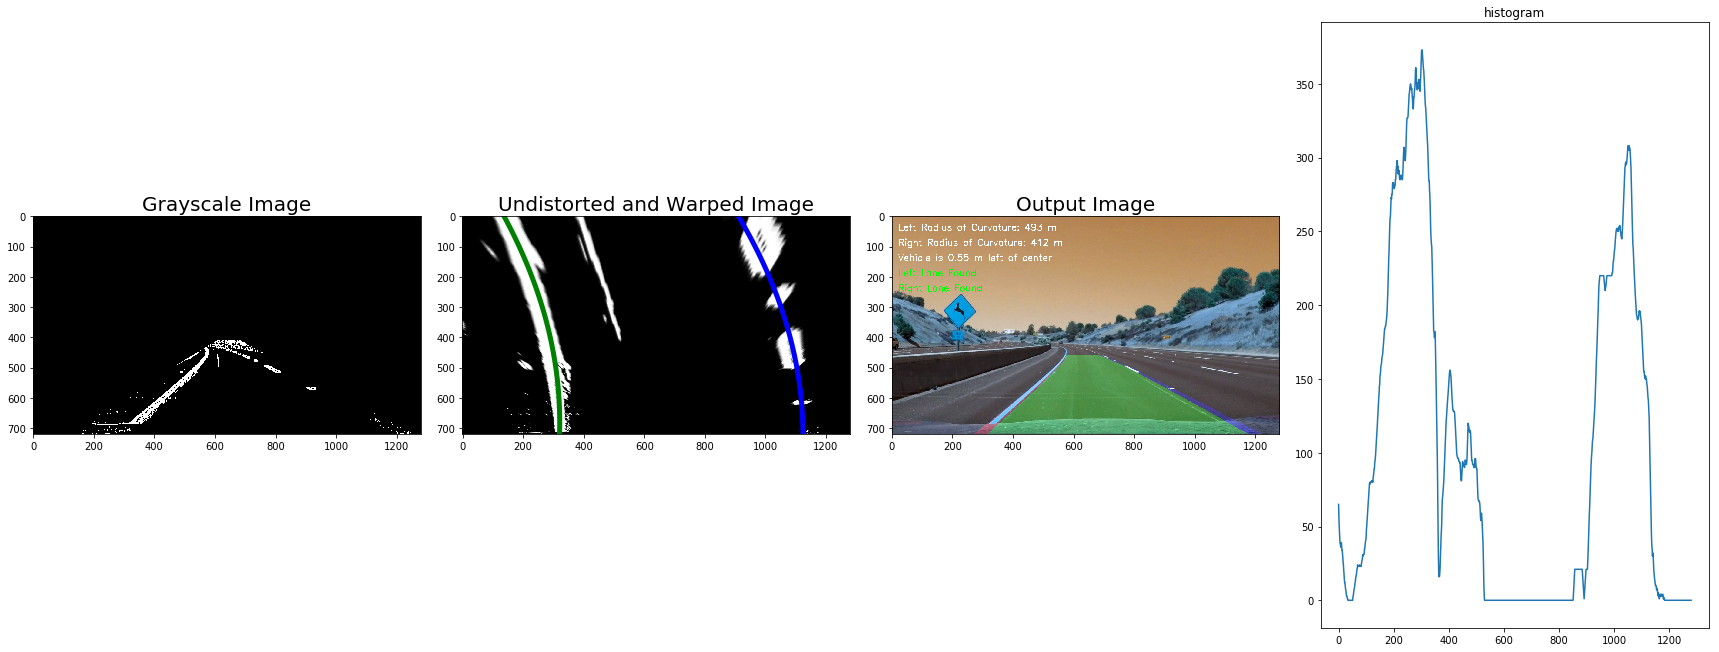

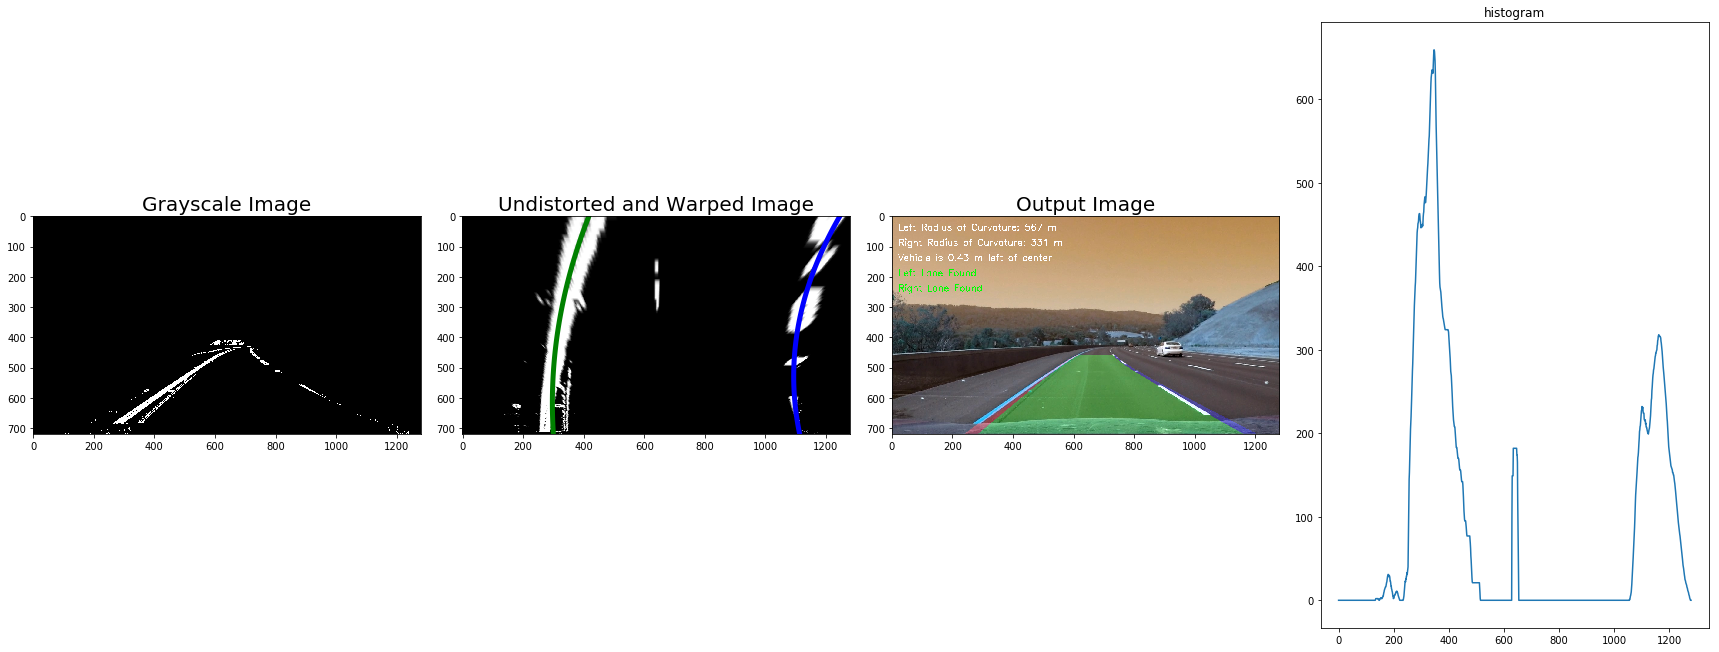

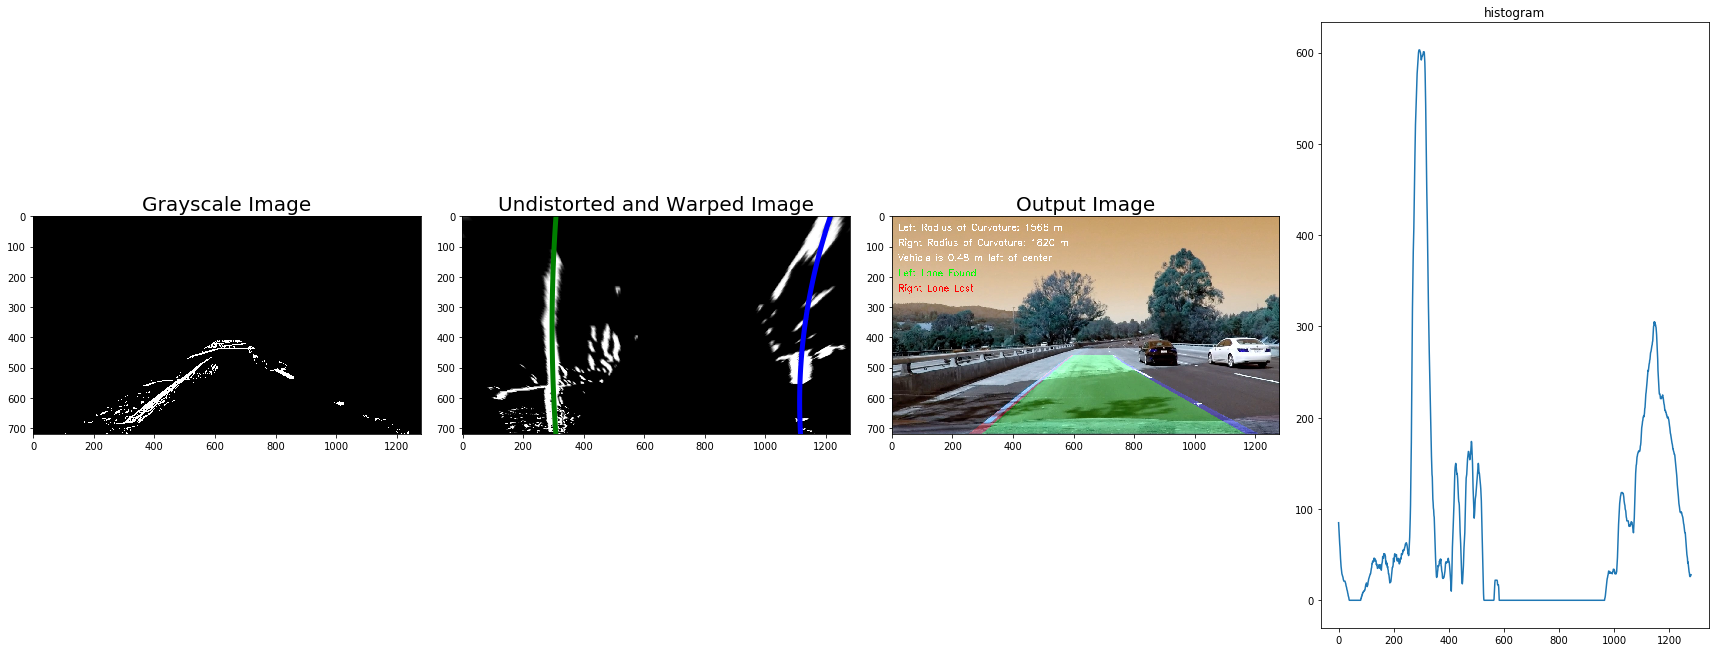

In [4]:

image_shape = image.shape
print("image shape:",image_shape)

# define the roi (guess and check)
area_of_interest = [[580,460],[710,460],[1150,720],[150,720]]


# class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #x values in windows
        self.windows = np.ones((3,12))*-1

###########################################################################################################        
# TODO: edit this so the measured radius of curvature makes more sense 
    
def find_curvature(yvals, fitx):
    # radius of curvature measurement to be taken at bottom  of image
    y_eval = np.max(yvals)
    
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension
    fit_cr = np.polyfit(yvals*ym_per_pix, fitx*xm_per_pix, 2)
    #curverad = ((1 + (2*fit_cr[0]*y_eval + fit_cr[1])**2)**1.5) \
    #                             /np.absolute(2*fit_cr[0])
    
    curverad = ((1 + (2*fit_cr[0]*y_eval*ym_per_pix + fit_cr[1])**2)**1.5) / np.absolute(2*fit_cr[0])

    
    return curverad

###########################################################################################################

def find_position(pts):
    # find position of car in the lane
    position = image_shape[1]/2
    left  = np.min(pts[(pts[:,1] < position) & (pts[:,0] > 700)][:,1])
    right = np.max(pts[(pts[:,1] > position) & (pts[:,0] > 700)][:,1])
    center = (left + right)/2
    
    # meters per pixel in x
    xm_per_pix = 3.7/700    
    return (position - center)*xm_per_pix


def find_nearest(array,value):
    # find the nearest point from array
    if len(array) > 0:
        idx = (np.abs(array-value)).argmin()
        return array[idx]

def find_peaks(image, y_window_top, y_window_bottom, x_left, x_right):
    # historgram from the image inside the window
    histogram = np.sum(image[y_window_top:y_window_bottom,:], axis=0)
    
    # max loc from the histogram
    if len(histogram[int(x_left):int(x_right)])>0:
        return np.argmax(histogram[int(x_left):int(x_right)]) + x_left
    else:
        return (x_left + x_right) / 2        

def sanity_check(lane, curverad, fitx, fit):       
    if lane.detected: # If lane is detected
        
        # if sanity check passes
        if abs(curverad / lane.radius_of_curvature - 1) < .6:        
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)            
            lane.radius_of_curvature = curverad
            lane.current_fit = fit
            
        # if sanity check fails use the previous values
        else:
            lane.detected = False
            fitx = lane.allx
    else:
        # if lane was not detected and no curvature is defined
        if lane.radius_of_curvature: 
            if abs(curverad / lane.radius_of_curvature - 1) < 1:            
                lane.detected = True
                lane.current_fit = fit
                lane.allx = fitx
                lane.bestx = np.mean(fitx)            
                lane.radius_of_curvature = curverad
                lane.current_fit = fit
            else:
                lane.detected = False
                fitx = lane.allx      
        # if curvature was defined
        else:
            lane.detected = True
            lane.current_fit = fit
            lane.allx = fitx
            lane.bestx = np.mean(fitx)
            lane.radius_of_curvature = curverad
    return fitx

# sanity check for the direction
def sanity_check_direction(right, right_pre, right_pre2):
    if abs((right-right_pre) / (right_pre-right_pre2) - 1) < .2:
        return right
    
    else:
        return right_pre + (right_pre - right_pre2)
    
# detect left and right lanes from the warped image using n histogram windows    
def find_lanes(n, image, x_window, lanes, \
               left_lane_x, left_lane_y, right_lane_x, right_lane_y, window_ind):

    # set placeholder
    index1 = np.zeros((n+1,2))
    index1[0] = [300, 1100]
    index1[1] = [300, 1100]
    
    # set initial left and right values
    left, right = (300, 1100)
    
    # set the center
    center = 640
    
    # set the previous center
    center_pre = center
    
    # set the direction
    direction = 0
    for i in range(n-1):
        # window range.
        y_window_top = int(720-720/n*(i+1))
        y_window_bottom = int(720-720/n*i)
        
        # if left and right lanes are detected from the previous image
        if (left_lane.detected==False) and (right_lane.detected==False):
            # compute historgram from the image inside the window
            left  = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,0]-200, index1[i+1,0]+200)
            right = find_peaks(image, y_window_top, y_window_bottom, index1[i+1,1]-200, index1[i+1,1]+200)
            
            # sanity check dir
            left  = sanity_check_direction(left, index1[i+1,0], index1[i,0])
            right = sanity_check_direction(right, index1[i+1,1], index1[i,1]) 
            
            # set the center 
            center_pre = center
            center = (left + right)/2
            direction = center - center_pre
        
        # If both lanes were detected in the previous image
        # Set them equal to the previous one
        else:
            left  = left_lane.windows[window_ind, i]
            right = right_lane.windows[window_ind, i]
            
        # Make sure the distance between left and right lanes are wide enough
        if abs(left-right) > 600:
            
            # append coords to left lane arrays
            left_lane_array = lanes[(lanes[:,1]>=left-x_window) & (lanes[:,1]<left+x_window) &
                                 (lanes[:,0]<=y_window_bottom) & (lanes[:,0]>=y_window_top)]
            left_lane_x += left_lane_array[:,1].flatten().tolist()
            left_lane_y += left_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(left_lane_array[:,1])):
                left_lane.windows[window_ind, i] = np.mean(left_lane_array[:,1])
                index1[i+2,0] = np.mean(left_lane_array[:,1])
            else:
                index1[i+2,0] = index1[i+1,0] + direction
                left_lane.windows[window_ind, i] = index1[i+2,0]
                
            # append coords to right lane arrays            
            right_lane_array = lanes[(lanes[:,1]>=right-x_window) & (lanes[:,1]<right+x_window) &
                                  (lanes[:,0]<y_window_bottom) & (lanes[:,0]>=y_window_top)]
            right_lane_x += right_lane_array[:,1].flatten().tolist()
            right_lane_y += right_lane_array[:,0].flatten().tolist()
            if not math.isnan(np.mean(right_lane_array[:,1])):
                right_lane.windows[window_ind, i] = np.mean(right_lane_array[:,1])
                index1[i+2,1] = np.mean(right_lane_array[:,1])
            else:
                index1[i+2,1] = index1[i+1,1] + direction
                right_lane.windows[window_ind, i] = index1[i+2,1]
    return left_lane_x, left_lane_y, right_lane_x, right_lane_y


# fit lines on perspective transformed image
def fit_lanes(image):
    # y coordinate values for plotting
    yvals = np.linspace(0, 100, num=101)*7.2  # to cover same y-range as image
    
    # find the coords from the image
    lanes = np.argwhere(image)
    
    # coords for left lane
    left_lane_x = []
    left_lane_y = []
    
    # coords for right lane
    right_lane_x = []
    right_lane_y = []
    
    # curve
    curve = 0
    
    # init left and right
    left = None
    right = None
    
    # find lanes from three repeated procedures with different window values
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(4, image, 25, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 0)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(6, image, 50, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 1)
    left_lane_x, left_lane_y, right_lane_x, right_lane_y \
        = find_lanes(8, image, 75, lanes, \
                     left_lane_x, left_lane_y, right_lane_x, right_lane_y, 2)
    
    # find polynomial coeffs
    left_fit = np.polyfit(left_lane_y, left_lane_x, 2)
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fit = np.polyfit(right_lane_y, right_lane_x, 2)
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]
    
    # find radii of curvature
    left_curverad  = find_curvature(yvals, left_fitx)
    right_curverad = find_curvature(yvals, right_fitx)
    
    # sanity check
    left_fitx  = sanity_check(left_lane, left_curverad, left_fitx, left_fit)
    right_fitx = sanity_check(right_lane, right_curverad, right_fitx, right_fit)
    
    return yvals, left_fitx, right_fitx, left_lane_x, left_lane_y, right_lane_x, right_lane_y, left_curverad, right_curverad

# draw polygon on the image
def draw_poly(image, warped, yvals, left_fitx, right_fitx, 
              left_lane_x, left_lane_y, right_lane_x, right_lane_y, Minv, left_curvature, right_curvature,
               right_lane, left_lane):
    
    # create empty array to draw on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
   
    # x and y points to be used for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))
    
    # draw on the blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # draw lane markers
    pts = np.transpose(np.vstack([left_fitx, yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=40)
    pts = np.transpose(np.vstack([right_fitx, yvals])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=40)
    
    # inverse perspective transform
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    
    # combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    
    # superimpose text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Left Radius of Curvature: {} m".format(int(left_curvature))
    cv2.putText(result,text,(20,50), font, 1,(255,255,255),2)
    
    text2 = "Right Radius of Curvature: {} m".format(int(right_curvature))
    cv2.putText(result,text2,(20,100), font, 1,(255,255,255),2)
    
    if(right_lane.detected):
        text = "Right Lane Found"
        cv2.putText(result, text, (20,250), font, 1, (0,255,0),2)
    else:
        text = "Right Lane Lost"
        cv2.putText(result, text, (20,250), font, 1, (255,0,0),2)
        
    if(left_lane.detected):
        text = "Left Lane Found"
        cv2.putText(result, text, (20,200), font, 1, (0,255,0),2)
    else:
        text = "Left Lane Lost"
        cv2.putText(result, text, (20,200), font, 1, (255,0,0),2)
    
    # find the position of the car relative to center
    pts = np.argwhere(newwarp[:,:,1])
    position = find_position(pts)
    
    if position < 0:
        text = "Vehicle is {:.2f} m left of center".format(-position)
    else:
        text = "Vehicle is {:.2f} m right of center".format(position)
    cv2.putText(result,text,(20,150), font, 1,(255,255,255),2)
    return result

# process and color the image
def process_image(image):
    img = highlight_lane_lines(image)
    
    # perspective transform
    top_down, perspective_M, perspective_Minv = warp(img, nx, ny, mtx, dist)
    
    # fit lines to left and right lane
    a, b, c, lx, ly, rx, ry, left_curvature, right_curvature = fit_lanes(top_down)
    
    # Return the original image with colored lane
    return draw_poly(image, top_down, a, b, c, lx, ly, rx, ry, perspective_Minv, left_curvature, right_curvature,
                    right_lane, left_lane)



# warp function
def warp(img, nx, ny, mtx, dist):
    
    # undistort
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    # offset from image corners to plot detected corners
    offset1 = 200 # offset for dst points x value
    offset2 = 0 # offset for dst points bottom y value
    offset3 = 0 # offset for dst points top y value
    
    img_size = (gray.shape[1], gray.shape[0])
    
    # grab outer 4 detected corners in src
    src = np.float32(area_of_interest)
    
    # choose points that make the warping look nice in dst image
    dst = np.float32([[offset1, offset3], 
                      [img_size[0]-offset1, offset3], 
                      [img_size[0]-offset1, img_size[1]-offset2], 
                      [offset1, img_size[1]-offset2]])
    
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    warped = cv2.warpPerspective(undist, M, img_size)

    return warped, M, Minv


###############################################
# show images for debugging and sanity checking
for i in range(1,5):

    # set up lines for left and right
    left_lane = Line()
    right_lane = Line()

    # load the image
    file_name = 'test_images/test{}.jpg'.format(i)
    img_raw = cv2.imread(file_name)

    # pipeline
    img = highlight_lane_lines(img_raw)

    # image undistort
    top_down, perspective_M, perspective_Minv = warp(img, nx, ny, mtx, dist)

    # set up for the subplots
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()

    # show the image from pipeline
    ax1.set_title('Grayscale Image', fontsize=20)
    ax1.imshow(img, cmap='gray')

    # find lanes from the warped image
    a, b, c, _, _, _, _, _, _ = fit_lanes(top_down)
    ax2.plot(b, a, color='green', linewidth=5)
    ax2.plot(c, a, color='blue', linewidth=5)
    ax2.imshow(top_down, cmap='gray')
    ax2.set_title('Undistorted and Warped Image', fontsize=20)

    # paint the lane lines
    image_color = process_image(img_raw)
    ax3.imshow(image_color)
    ax3.set_title('Output Image', fontsize=20)

    # plot image histograms
    top_down[top_down > 0] = 1

    hist = np.sum(top_down, axis=0)
    ax4.plot(hist)
    ax4.set_title("histogram")


In [5]:
### Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
left_lane = Line()
right_lane = Line()
white_output = 'project4_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video project4_output.mp4
[MoviePy] Writing video project4_output.mp4


100%|█████████▉| 1260/1261 [07:43<00:00,  2.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project4_output.mp4 

CPU times: user 9min 2s, sys: 6.54 s, total: 9min 9s
Wall time: 7min 45s
